In [1]:
import json
import os
import copy
import time
import torch
import torchvision
import torchvision.transforms as transforms
from models.CLIP import *
from utils.get_data import data
from utils.get_data import get_data
from utils.data_utils import build_subset, split_train_and_val
from utils.json_utils import generate_json_config

import warnings
warnings.simplefilter("ignore")

torch.manual_seed(1)
torch.cuda.manual_seed(1) if torch.cuda.is_available() else None

/opt/conda/envs/fl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = globals()['data']
dataset

['Clipart', 'Painting', 'Real', 'Sketch', 'Quickdraw', 'Infograph']

In [3]:
train_preprocess = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            transforms.Resize((224, 224))
                            ])
cds = []
for id, data_name in enumerate(dataset):
    cd = get_data(data_name, train_preprocess, train_preprocess, f'./data/{data_name}', 128, 12)
    cd = build_subset(cd, 10)
    cds.append(cd)

#build a resnet50 model with 10 classes
model = torchvision.models.resnet50(pretrained=False, num_classes=10).to('cuda')

In [4]:
model1 = copy.deepcopy(model)
model2 = copy.deepcopy(model)
model3 = copy.deepcopy(model)

def train(cd, model):
    print('Training model')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    for epoch in range(10):
        for image, label in cd:
            image = image.to('cuda')
            label = label.to('cuda')
            out = model(image)
            loss = torch.nn.functional.cross_entropy(out, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    return model

model1 = train(cds[0].train_loader, model1)
model2 = train(cds[1].train_loader, model2)
model3 = train(cds[2].train_loader, model3)

Training model


Could not load library libcudnn_cnn_train.so.8. Error: /usr/local/cuda/lib64/libcudnn_cnn_train.so.8: undefined symbol: _ZN5cudnn3cnn34layerNormFwd_execute_internal_implERKNS_7backend11VariantPackEP11CUstream_stRNS0_18LayerNormFwdParamsERKNS1_20NormForwardOperationEmb, version libcudnn_cnn_infer.so.8
Could not load library libcudnn_cnn_train.so.8. Error: /usr/local/cuda/lib64/libcudnn_cnn_train.so.8: undefined symbol: _ZN5cudnn3cnn34layerNormFwd_execute_internal_implERKNS_7backend11VariantPackEP11CUstream_stRNS0_18LayerNormFwdParamsERKNS1_20NormForwardOperationEmb, version libcudnn_cnn_infer.so.8
Could not load library libcudnn_cnn_train.so.8. Error: /usr/local/cuda/lib64/libcudnn_cnn_train.so.8: undefined symbol: _ZN5cudnn3cnn34layerNormFwd_execute_internal_implERKNS_7backend11VariantPackEP11CUstream_stRNS0_18LayerNormFwdParamsERKNS1_20NormForwardOperationEmb, version libcudnn_cnn_infer.so.8
Could not load library libcudnn_cnn_train.so.8. Error: /usr/local/cuda/lib64/libcudnn_cnn_trai

RuntimeError: GET was unable to find an engine to execute this computation

: 

In [1]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms

import shap

/opt/conda/envs/fl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
batch_size = 128
num_epochs = 2
device = torch.device("cpu")


class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
                f" ({100.0 * batch_idx / len(train_loader):.0f}%)]"
                f"\tLoss: {loss.item():.6f}"
            )


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[
                1
            ]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(
        f"\nTest set: Average loss: {test_loss:.4f},"
        f" Accuracy: {correct}/{len(test_loader.dataset)}"
        f" ({100.0 * correct / len(test_loader.dataset):.0f}%)\n"
    )


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "mnist_data",
        train=True,
        download=True,
        transform=transforms.Compose([transforms.ToTensor()]),
    ),
    batch_size=batch_size,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "mnist_data", train=False, transform=transforms.Compose([transforms.ToTensor()])
    ),
    batch_size=batch_size,
    shuffle=True,
)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301430
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.195976
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.346307
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.800198
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.695470

Test set: Average loss: 0.0046, Accuracy: 8938/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.709231
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.436415
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.519054
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.404633
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.625304

Test set: Average loss: 0.0026, Accuracy: 9380/10000 (94%)



In [3]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, _ = batch

background = images[:100]
test_images = images[100:103]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

In [12]:
test_images.shape

torch.Size([3, 1, 28, 28])

In [13]:
shap_values.shape

(3, 1, 28, 28, 10)

TypeError: Invalid shape (1, 28, 28) for image data

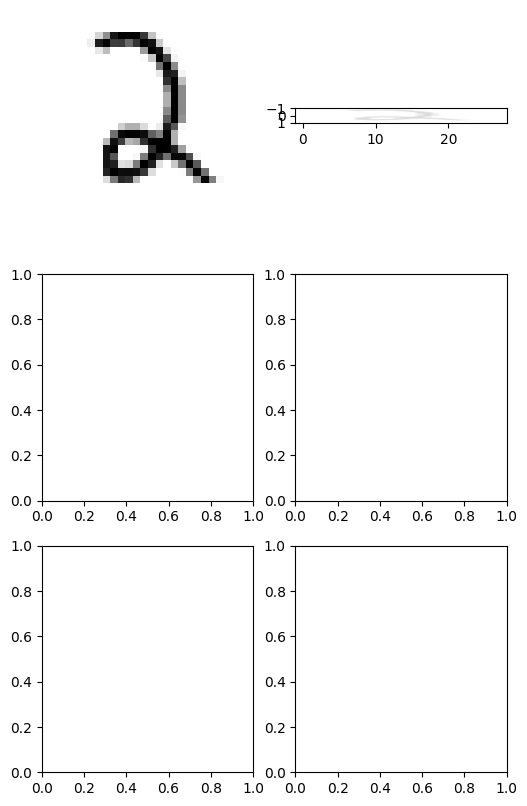

In [14]:
shap.image_plot(shap_values, -test_images.numpy().transpose(0, 2, 3, 1))

In [4]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

IndexError: index 1 is out of bounds for axis 0 with size 1

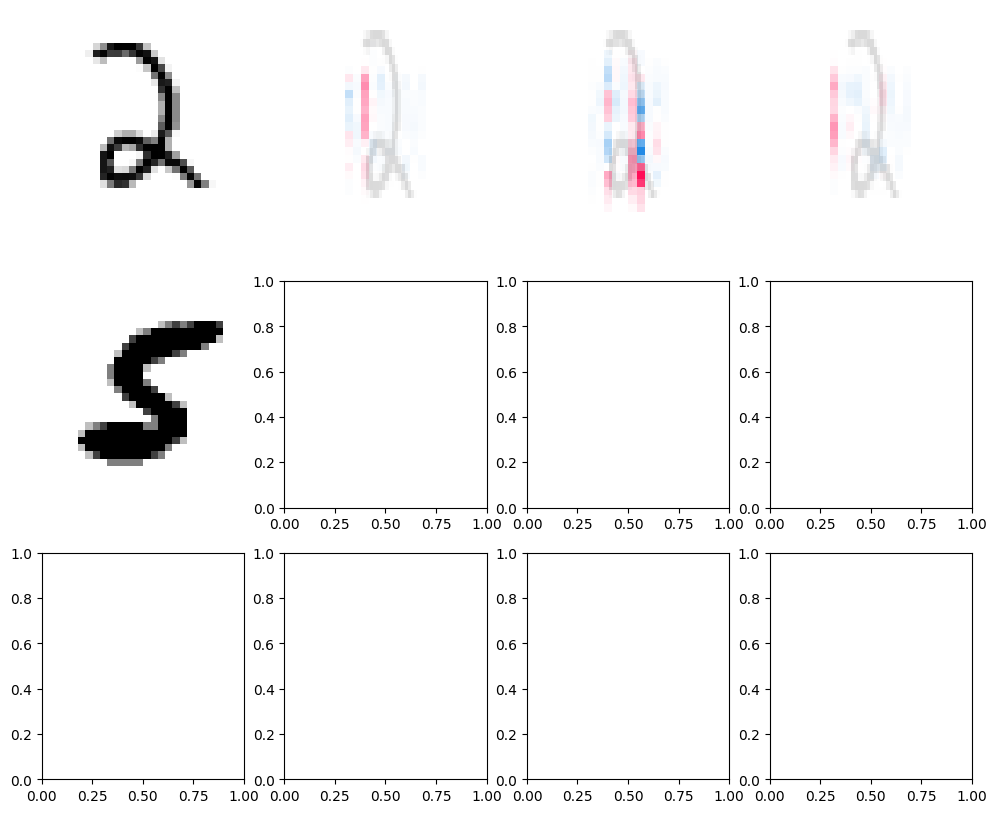

In [5]:
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)

In [17]:
import keras
import numpy as np
from keras import layers
from keras.utils import to_categorical

import shap

# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

batch_size = 128
epochs = 3

model = keras.Sequential(
    [
        layers.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3


AttributeError: module 'keras.src.backend' has no attribute 'convert_to_numpy'

: 

In [ ]:
# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# explain predictions of the model on three images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[0:5])

In [ ]:
# plot the feature attributions
shap.image_plot(shap_values, -x_test[0:5])